In [1]:
#from pyimzml.ImzMLParser import ImzMLParser
import time
import matplotlib.pyplot as plt
import re
import scipy.signal
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pickle
#from joblib import Parallel, delayed
from scipy.optimize import curve_fit
from math import cos, degrees, pi, log, radians
from Mylib import *
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, mean_shift, DBSCAN
%matplotlib notebook

from matplotlib import colors as clr
import matplotlib

def new_nei_set(alpha, cols_bin, perc):
    return np.flatnonzero(cols_bin[alpha]>perc)

In [2]:
cl=[(1.0,0.0,0.0,1),
(1.0,1.0,0.0,1),
(0.0,1.0,0.0,1),
(0.0,1.0,1.0,1),
(153/255,51/255,1.0,1),
(1,51/255,1,1), (0.0,0.0, 1.0, 1), (1.0,0.0,1.0,1),(0.0,0.5,0.5,1), (192/255, 192/255,192/255,1) ]   

## TOC:
* [Calculation of optimal angles](#first-bullet)
* [Greedy algorithm](#second-bullet)
* [Preliminary segmentation](#third-bullet)
* [Разные углы для двух зон](#fourth-bullet)
* [Картинки для трех, четырех зон](#fifth-bullet)

In [3]:
#folder=str("Human_Brains_2020")
folder=str("Mouse_feb_2022")
#folder=("Rats_2022")

In [4]:
#Reading the data
name=input("Which pickle is to be taken?\n")
try: 
    f=open('D:\\_PICKLES\\'+folder+'\\'+name+'_v.pickle', 'rb')
    print("Done!")
    vv=pickle.load(f)
    g=open('D:\\_PICKLES\\'+folder+'\\'+name+'_x.pickle', 'rb')
    xx=pickle.load(g)
    h=open('D:\\_PICKLES\\'+folder+'\\'+name+'_y.pickle', 'rb')
    yy=pickle.load(h)

SyntaxError: unexpected EOF while parsing (3159045513.py, line 10)

In [7]:
name=input("Which pickle is to be taken?\n")

Which pickle is to be taken?
spring_mouse1


In [ ]:
f=open('D:\\_PICKLES\\'+folder+'\\'+name+'_v.pickle', 'rb')
print("Done!")
vv=pickle.load(f)
g=open('D:\\_PICKLES\\'+folder+'\\'+name+'_x.pickle', 'rb')
xx=pickle.load(g)
h=open('D:\\_PICKLES\\'+folder+'\\'+name+'_y.pickle', 'rb')
yy=pickle.load(h)

# Calculation of optimal angles <a class="anchor" id="first-bullet"></a>

In [14]:
 # Надо проверять, что delta_phi<этого угла
number0=len(vv)
cols_bin=1-pairwise_distances(vv, vv, metric="cosine")
min_angle=np.arccos(np.sort(cols_bin, axis=None)[-number0-1])
print("Минимальный угол между точками ", min_angle, " радиан")

Минимальный угол между точками  0.031536520865894334  радиан


In [15]:
%%time
# alpha -- плотность для каждой точки, extr_phi -- соответствующий экстремальный угол
delta_phi=min_angle/10
print(int(ceil(1/delta_phi)))

alpha1=[]
extr_phi1=[]
logx=np.array([degrees(i*delta_phi) for i in range(3, int(ceil(1/delta_phi)))])
for i in range(number0):
    if(i%10000==0):
        print(i)
    logy=np.array([(log(len(new_nei_set(i, cols_bin, cos(k*delta_phi)))))/log(k) for k in range (3, int(ceil(1/delta_phi)))], dtype=float)
    alpha1.append(np.amax(logy))
    extr_phi1.append(degrees((np.argmax(logy)+2)*delta_phi))
alpha1=np.array(alpha1)
extr_phi1=np.array(extr_phi1)

318
0
10000
20000
30000
40000
50000
Wall time: 13min 54s


In [16]:
# Отсеивание выбросов
z=np.flatnonzero(extr_phi1>45)
print("Количество выбросов равно ", len(z))
ileft= np.array(list({j for j in range(number0)}.difference(set(z))))
x=xx[ileft]
y=yy[ileft]
v=np.array([vv[ileft[i]] for i in range(len(ileft))])
alpha=alpha1[ileft]
extr_phi=extr_phi1[ileft]

Количество выбросов равно  222


In [17]:
del(cols_bin)
cols_bin=1-pairwise_distances(v, v, metric="cosine")
mincos=np.amin(cols_bin, axis=None)
number=len(v)

# Greedy algorithm <a class="anchor" id="second-bullet"></a>

In [14]:
#key=1 #углы разные
key=2 #угол один и тот же.
#key=3 #смешанный

In [15]:
mincos=np.amin(cols_bin, axis=None)
num_opt=np.argmax(alpha)
med_phi=np.median(extr_phi) #медианный угол в градусах
cos_opt=cos(radians(extr_phi[num_opt])) #соответсвующий самому плотному
#cos_opt=cos(radians(np.median(extr_phi))) #медианный
#cos_opt=cos(np.arccos(mincos)/10) #максимальный разделить на 10

In [11]:
print(np.median(extr_phi), degrees(np.arccos(mincos)/10), extr_phi[num_opt], np.amin(extr_phi))

8.673165821481609 6.016205240659547 4.878655774583405 4.517273865355005


In [16]:
%%time
# Заполняем cone_matr -- матрицу нулей и единиц, конусы в каждой точке с углом равным соответствующему самой плотной точке. в i-ой строке 0, если соотв.точка -- сосед
# len_list -- мощности конусов
len_list=np.zeros(number, dtype=int)
cone_matr=np.ones((number, number), dtype=bool) 
        
if(key==2):
    for i in range(number):
        temp=new_nei_set(i, cols_bin, cos_opt)
        len_list[i]=len(temp)
        for j in temp:
            cone_matr[i][j]=0
elif (key==1):
    for i in range(number):
        temp=new_nei_set(i, cols_bin, cos(radians(extr_phi[i])))
        len_list[i]=len(temp)
        for j in temp:
            cone_matr[i][j]=0
elif(key==3):
    cos_opt=cos(radians(med_phi))
    for i in range(number):
        if(extr_phi[i]<med_phi):
            temp=new_nei_set(i, cols_bin, cos(radians(extr_phi[i])))
        else:
            temp=new_nei_set(i, cols_bin, cos_opt)
        len_list[i]=len(temp)
        for j in temp:
            cone_matr[i][j]=0

Wall time: 20.7 s


In [19]:
%%time
nums=np.array([num_opt])
temp=np.prod(cone_matr.T[np.flatnonzero(cone_matr[num_opt]==0)], axis=0) #массив ноликов и единичек
good_nums=np.flatnonzero(temp) #номера хороших точек

print("median=", med_phi)
while len(good_nums)>0:
    #num_t=good_nums[np.argmax(alpha[good_nums])]
    if(key==1):
        num_t=good_nums[np.argmax(alpha[good_nums])]
    elif(key==2):
        num_t=good_nums[np.argmax(len_list[good_nums])]
        #num_t=good_nums[np.argmax(alpha[good_nums])]
#     elif(key==3):
#         num_t=good_nums[np.argmax(alpha[good_nums])]
#         if(med_phi>extr_phi[num_t]):
#             print("The point is ", num_t, ". The angle is small: ", extr_phi[num_t])
#         else:
#             print("The point is ", num_t, ". The angle is med: ", med_phi)
    #print(num_t)
    nums=np.append(nums, num_t)
    temp=temp*np.prod(cone_matr.T[np.flatnonzero(cone_matr[num_t]==0)], axis=0)
    good_nums=np.flatnonzero(temp)
    if(len_list[num_t]==1):
        break

median= 8.673165821481609
Wall time: 21 s


<IPython.core.display.Javascript object>


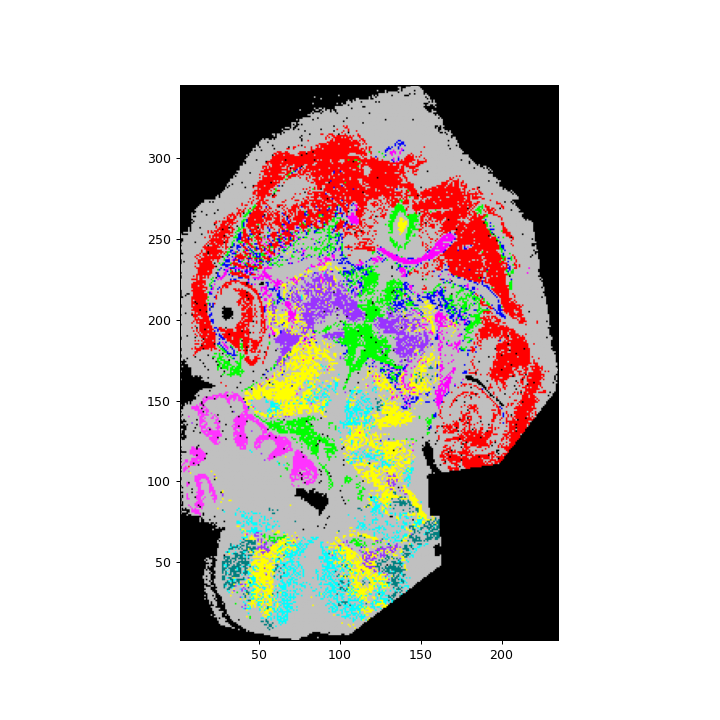

In [20]:
#Сетка для картинок
extent = np.min(x), np.max(x), np.min(y), np.max(y)
xgrid=np.arange(extent[0]-0.5, extent[1]+0.5, 1)
ygrid=np.arange(extent[2]-0.5, extent[3]+0.5, 1)

Z0=[[(0.0,0.0,0.0,1.0) for j in range(len(xgrid))] for i in range(len(ygrid))]

# Картинка для трех зон с одинаковым углом
cols4=np.array([cl[-1] for i in range(number)])

if(key==2):
    for j in range(min(len(nums), 10)):
        for i in new_nei_set(nums[j], cols_bin, cos_opt):
            cols4[i]=cl[j]    
elif (key==1):
    for j in range(min(len(nums), 10)):
        for i in new_nei_set(nums[j], cols_bin, cos(radians(extr_phi[nums[j]]))):
            cols4[i]=cl[j]
elif (key==3):
    for j in range(min(len(nums), 10)):
        if(extr_phi[nums[j]]<med_phi):
            for i in new_nei_set(nums[j], cols_bin, cos(radians(extr_phi[nums[j]]))):
                cols4[i]=cl[j]
        else:
            for i in new_nei_set(nums[j], cols_bin, cos_opt):
                cols4[i]=cl[j]
Z2=Z0

for i in range(len(x)):
    Z2[extent[3]-y[i]][x[i]-extent[0]]=cols4[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
plt.show()

# Preliminary segmentation<a class="anchor" id="third-bullet"></a>

In [18]:
number=len(v)
#cols_bin=1-pairwise_distances(v, v, metric="cosine")
#mincos=np.amin(cols_bin, axis=None)
reg_num=4
if(reg_num==0):
    coneangle=cos(radians(np.median(extr_phi)))
elif(reg_num>0):
    coneangle=cos(np.arccos(mincos)/2/reg_num)
else:
    print("There is an error")

print("Максимальный угол равен "+str(degrees(np.arccos(mincos)))+" degrees")
print("Number of points in the image is "+str(number))

Максимальный угол равен 60.162052406595464 degrees
Number of points in the image is 57098


In [34]:
%%time
#arrofnei_new -- матрица number*number, где в i-ой строке на местах соседей с углом coneangle стоят нули, остальные -- единицы
#arr_of_notnei -- матрица number*number, где в i-ой строке нули стоят там, где хотя бы у одного из её соседей данная точка -- сосед
lenlist=np.zeros(number, dtype=int)
arrofnei_new=np.ones((number, number), dtype=bool)
for i in range(number):
    nei_temp=new_nei_set(i, cols_bin, coneangle)
    for j in nei_temp:
        arrofnei_new[i][j]=0
    lenlist[i]=len(nei_temp)
arr_of_notnei=np.array([np.prod(arrofnei_new.T[np.flatnonzero(arrofnei_new[j]==0)], axis=0) for j in range(number)])  

Wall time: 2d 23h 36min 4s


# Три множества

In [15]:
%%time
#Предварительное разбиение с углом coneangle
lentemp=0
for i in range(number):
    set0=np.flatnonzero(arr_of_notnei[i][i:])+i
    for j in set0:
        set1=np.flatnonzero((arr_of_notnei[i]*arr_of_notnei[j])[j:])+j            
        if(len(set1)):
            answ1=np.argmax(lenlist[set1])
            answ2=set1[answ1]
            if(lenlist[i]+lenlist[j]+lenlist[answ2]>lentemp):
                bestnum1=i
                bestnum2=j
                bestnum3=answ2
                lentemp=lenlist[i]+lenlist[j]+lenlist[answ2]
arr_answ=np.array([bestnum1, bestnum2, bestnum3])

97.87352252006531
Wall time: 1min 37s


In [11]:
print(lenlist[arr_answ])

[ 506 2073 2518]


In [31]:
%%time
# set_of_sets -- матрица num_of_reg*number, где в i-ой строке нули стоят на местах точек i-ого множества (т.е. соседей "базисной")
# phi_set -- набор новых углов
num_of_reg=3
set_of_sets=arrofnei_new[arr_answ]
phi_set=np.array([cos(radians(np.median(extr_phi[np.flatnonzero(set_of_sets[k-1]==0)])))  for k in range(num_of_reg)])

new_lenlist=np.zeros(number, dtype=int)
setlist=np.zeros((num_of_reg, number), dtype=bool) #в k-ой строке стоят единицы на месте элементов из k-ого сета
nei_arr=np.ones((number, number), dtype=bool) # если i лежит в Set_j, то в i-ой строке на месте всех соседей с углом phi_j лежат нули, а в остальных (в несоседях) лежат единицы. 
#Если i не лежит ни в одном Set'e, то вся строка из единиц (вроде не пользуемся ею)

for k in range(num_of_reg):
    Set_temp=np.flatnonzero(arrofnei_new[arr_answ[k]]==0) #Номера точек в k-ом сете
    for i in (Set_temp):
        setlist[k][i]=1
        nei_temp=new_nei_set(i, cols_bin, phi_set[k])
        for j in nei_temp:
            nei_arr[i][j]=0
        new_lenlist[i]=number-np.sum(nei_arr[i])

Wall time: 2.36 s


In [ ]:
#to do: setlist+set_of_sets==1. нужно избавиться от одной из переменных (от set of sets. 1-set-of-sets не работает -- становятся int'ом)

In [41]:
%%time
# Новые несоседи
not_nei_arr=np.array([np.prod(nei_arr.T[np.flatnonzero(nei_arr[j]==0)], axis=0) for j in range (number)], dtype=bool)

Wall time: 4min 38s


In [36]:
%%time
#альтернативный код. Сравнить скорость
not_nei_arr1=np.zeros((number,number), dtype=bool)
for k in range(num_of_reg):
    Set_temp=np.flatnonzero(arrofnei_new[arr_answ[k]]==0)
    for j in Set_temp:
        not_nei_arr1[j]=np.prod(nei_arr.T[np.flatnonzero(nei_arr[j]==0)], axis=0)

Wall time: 4min 35s


In [42]:
%%time
# Три множества уточненное
set0=np.flatnonzero(setlist[0])
jlen=0
for i in set0:
    set1=np.flatnonzero(not_nei_arr[i]*setlist[1])
    for j in set1:
        set2=np.flatnonzero(not_nei_arr[j]*not_nei_arr[i]*setlist[2]) #не имеющие общих соседей с i-ой, не имеющие общих соседей с j-ой и из третьего множества
        if(len(set2)):
            answ1=np.argmax(new_lenlist[set2])
            answ2=set2[answ1]
            if(new_lenlist[answ2]+new_lenlist[i]+new_lenlist[j]>jlen):
                atemp=np.full(number, 0)
                atemp[i]=1
                atemp[j]=1
                atemp[answ2]=1     
                jlen=new_lenlist[answ2]+new_lenlist[i]+new_lenlist[j]

1.21665620803833


In [43]:
fin_ans=np.flatnonzero(atemp)
print(fin_ans, new_lenlist[fin_ans])

[1472 2999 3235] [ 121 2467 2833]


In [45]:
final_set1=np.flatnonzero(nei_arr[fin_ans[0]]==0)
final_set2=np.flatnonzero(nei_arr[fin_ans[1]]==0)
final_set3=np.flatnonzero(nei_arr[fin_ans[2]]==0)

In [55]:
#Сетка для картинок
extent = np.min(x)/3, np.max(x)/3, np.min(y)/3, np.max(y)/3
xgrid=np.arange(extent[0]-0.5, extent[1]+0.5, 1)
ygrid=np.arange(extent[2]-0.5, extent[3]+0.5, 1)

Z0=[[(0.0,0.0,0.0,1.0) for j in range(len(xgrid))] for i in range(len(ygrid))]

In [56]:
cols5=np.array([cl[-1] for i in range(number)])
for i in final_set1: 
    cols5[i]=cl[1]
for i in final_set2:
    cols5[i]=cl[0]
for i in final_set3:
    cols5[i]=cl[2]

Z2=Z0

for i in range(len(x)):
    Z2[int(extent[3]-y[i]/3)][int(x[i]/3-extent[0])]=cols5[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
plt.show() 

TypeError: list indices must be integers or slices, not numpy.float64

# Четыре множества 

In [35]:
%%time
lentemp=0
for i in range(number):
    set0=np.flatnonzero(arr_of_notnei[i][i:])+i
    for j in set0:
        set1=np.flatnonzero((arr_of_notnei[i]*arr_of_notnei[j])[j:])+j   
        for k in set1:
            set2=np.flatnonzero((arr_of_notnei[i]*arr_of_notnei[j]*arr_of_notnei[k])[k:])+k
            if(len(set2)):
                answ1=np.argmax(lenlist[set2])
                answ2=set2[answ1]
                if(lenlist[i]+lenlist[j]+lenlist[k]+lenlist[answ2]>lentemp):
                    bestnum1=i
                    bestnum2=j
                    bestnum3=k
                    bestnum4=answ2
                    lentemp=lenlist[i]+lenlist[j]+lenlist[k]+lenlist[answ2]

arr_answ=np.array([bestnum1, bestnum2, bestnum3, bestnum4])

KeyboardInterrupt: 

In [36]:
arr_answ

NameError: name 'arr_answ' is not defined

In [ ]:
%%time
num_of_reg=4
set_of_sets=arrofnei_new[arr_answ]
phi_set=np.array([cos(radians(np.median(extr_phi[np.flatnonzero(set_of_sets[k-1]==0)])))  for k in range(num_of_reg)])

new_lenlist=np.zeros(number, dtype=int)
setlist=np.zeros((num_of_reg, number), dtype=bool) #в k-ой строке стоят единицы на месте элементов из k-ого сета
nei_arr=np.ones((number, number), dtype=bool) # если i лежит в Set_j, то в i-ой строке на месте всех соседей с углом phi_j лежат нули, а в остальных (в несоседях) лежат единицы. 
#Если i не лежит ни в одном Set'e, то вся строка из единиц (вроде не пользуемся ею)

for k in range(num_of_reg):
    Set_temp=np.flatnonzero(arrofnei_new[arr_answ[k]]==0) #Номера точек в k-ом сете
    for i in (Set_temp):
        setlist[k][i]=1
        nei_temp=new_nei_set(i, cols_bin, phi_set[k])
        for j in nei_temp:
            nei_arr[i][j]=0
        new_lenlist[i]=number-np.sum(nei_arr[i])

In [ ]:
%%time
not_nei_arr=np.array([np.prod(nei_arr.T[np.flatnonzero(nei_arr[j]==0)], axis=0) for j in range (number)], dtype=bool)

In [ ]:
%%time
#альтернативный код. Сравнить скорость
not_nei_arr1=np.zeros((number,number), dtype=bool)
for k in range(num_of_reg):
    Set_temp=np.flatnonzero(arrofnei_new[arr_answ[k]]==0)
    for j in Set_temp:
        not_nei_arr1[j]=np.prod(nei_arr.T[np.flatnonzero(nei_arr[j]==0)], axis=0)

In [ ]:
%%time
# Refinement
set0=np.flatnonzero(setlist[0])
jlen=0
for i in set0:
    set1=np.flatnonzero(not_nei_arr[i]*setlist[1])
    for j in set1:
        set2=np.flatnonzero(not_nei_arr[j]*not_nei_arr[i]*setlist[2]) #не имеющие общих соседей с i-ой, не имеющие общих соседей с j-ой и из третьего множества
        for k in set2:
            set3=np.flatnonzero(not_nei_arr[i]*not_nei_arr[j]*not_nei_arr[k]*setlist[3])
            if(len(set3)):
                answ1=np.argmax(new_lenlist[set3])
                answ2=set3[answ1]
                if(new_lenlist[answ2]+new_lenlist[i]+new_lenlist[j]+new_lenlist[k]>jlen):
                    atemp=np.full(number, 0)
                    atemp[i]=1
                    atemp[j]=1
                    atemp[answ2]=1   
                    atemp[k]=1
                    jlen=new_lenlist[answ2]+new_lenlist[i]+new_lenlist[j]+new_lenlist[k]

fin_ans=np.flatnonzero(atemp)
print(fin_ans)

In [ ]:
final_set1=np.flatnonzero(nei_arr[fin_ans[0]]==0)
final_set2=np.flatnonzero(nei_arr[fin_ans[1]]==0)
final_set3=np.flatnonzero(nei_arr[fin_ans[2]]==0)
final_set4=np.flatnonzero(nei_arr[fin_ans[3]]==0)

In [ ]:
#Сетка для картинок
extent = np.min(x)/3, np.max(x)/3, np.min(y)/3, np.max(y)/3
xgrid=np.arange(extent[0]-0.5, extent[1]+0.5, 1)
ygrid=np.arange(extent[2]-0.5, extent[3]+0.5, 1)

Z0=[[(0.0,0.0,0.0,1.0) for j in range(len(xgrid))] for i in range(len(ygrid))]

In [ ]:
cols5=np.array([cl[-1] for i in range(number)])
for i in final_set1: 
    cols5[i]=cl[1]
for i in final_set2:
    cols5[i]=cl[0]
for i in final_set3:
    cols5[i]=cl[2]
for i in final_set4:
    cols5[i]=cl[3]    

Z2=Z0

for i in range(len(x)):
    Z2[int(extent[3]-y[i]/3)][int(x[i]/3-extent[0])]=cols5[i]

fig1 = plt.figure(figsize=(8,8), frameon=False)
im1 = plt.imshow(Z2, extent=extent)
#fig1.suptitle("Number of points in each part is  "+str(len(final_set21))+", "+str(len(final_set22))+", "+str(len(final_set23))+" respectively")
plt.show() 

# Классные были функции...

In [ ]:
# выдает число и одномерный массив длины number -- где единицы - там номера величин >=i из defset'а, доставляющих максимум суммы длин, число -- эта сумма длин. 
# Аргументы: i - номер точки, >= которой рассматриваем номера, defset -- масссив длины number из нулей и единиц. Единицы - те номера, которые рассматриваем. Номера в defset никак не связаны с номером i 
def the_function(i, defset, arrnotnei, lenlist, depth): #что делать с точкой i=0
    if(len(defset)==0):
        return np.full(2, 0)
    N=len(lenlist)
    if(depth<=1):
        arr0=np.flatnonzero(defset[i:])+i #сразу номера хороших
        if(len(arr0)):
            lenarr0=np.array([lenlist[i] for i in arr0])
            maxv=np.argmax(lenarr0)
            atemp=np.full(N, 0)
            atemp[arr0[maxv]]=1
            return lenarr0[maxv], atemp
        else:
            return 0, np.full(N,0)
    else:
        jlen=0
        atemp=np.full(N, 0)
        arr0=np.flatnonzero(defset[i+1:])+i+1
        for j in arr0: #в arr0 уже номера больше i
            sumlen, arrtemp=the_function(j, defset*arrnotnei[j], arrnotnei, lenlist, depth-1)
            if(sumlen):
                if(lenlist[j]+sumlen>jlen):
                    jlen=lenlist[j]+sumlen
                    atemp=arrtemp
                    atemp[j]=1
        return jlen, atemp


In [ ]:
def refined_function(defset, neiarr, lenlist, setlist, depth, number): 
#возвращает массив и число. Массив - это номера точек, каждая из соответствующего сета (Set_1... (Set_depth-1)) и лежащая в defset, такие, что сумма мощностей конусов максимальна. Число - это та самая сумма мощностей.
# Аргументы: defset -- множество, из которого должны быть все точки (массив из нулей и единиц длины number), neiarr -- массив нулей и единиц, 
#setlist - массив длины number из чисел 0,..., n (количество регионов), на i-ом месте стоит номер региона, в который входит точка (0, если совсем никуда не входит)
    if(depth==1):
        a=setlist[0]
        c=np.flatnonzero(a*defset)
        if(len(c)):
            answ1=np.argmax(lenlist[c])
            answ2=c[answ1]
            atemp=np.full(number, 0)
            atemp[answ2]=1
            return lenlist[answ2], atemp
        else:
            return 0, np.full(number, 0)
    else:
        jlen=0
        jarr=np.full(number,0)
        a=setlist[depth-1] #set_depth в виде нулей и единиц
        c=np.flatnonzero(a*defset)
        for i in c: #по всем точкам из Set_depth ищем оставшийся набор среди точек из defset'a и хороших для точки i точек.
            nei_i=np.flatnonzero(neiarr[i]==0) #номера всех соседей i-ой
            good_set=np.prod(neiarr.T[nei_i], axis=0) # множество точек, у которых соседи i-ой не являются соседями
            answ1, answ2=refined_function(good_set*defset, neiarr, lenlist, setlist, depth-1, number)
            if(answ1):
                if(answ1+lenlist[i]>jlen):
                    jlen=answ1+lenlist[i]
                    jarr=answ2
                    jarr[i]=1
        return jlen, jarr

In [ ]:
#предварительное разбиение
num_of_reg=4
starttime=time.time()
answ1, answ2= the_function(0, np.ones(number, dtype=bool), arrof_not_nei, lenlist, num_of_reg)
arr_answ=np.flatnonzero(answ2)
print(answ1, arr_answ)
endtime=time.time()
print(endtime-starttime)

In [ ]:
starttime=time.time()
answ11, answ22=refined_function(np.ones(number), nei_arr, new_lenlist, setlist, num_of_reg, number)
endtime=time.time()
print(endtime-starttime)

print(answ11, np.flatnonzero(answ22))

In [ ]:
# # Три множества
# starttime=time.time()
# set0=np.flatnonzero(setlist[0])
# jlen=0
# for i in set0:
#     nei_i=np.flatnonzero(nei_arr[i]==0) #соседи той точки из первого множества
#     good_set_0=np.prod(nei_arr.T[nei_i], axis=0) # множество точек, у которых соседи i-ой не являются соседями... и их пересечение с вторым множеством
#     set1=good_set_0*setlist[1]
#     for j in set1:
#         nei_j=np.flatnonzero(nei_arr[j]==0)
#         good_set_1=np.prod(nei_arr.T[nei_j], axis=0)*good_set_0*setlist[2] #не имеющие общих соседей с i-ой, не имеющие общих соседей с j-ой и из третьего множества
#         c=np.flatnonzero(good_set_1)
#         if(len(c)):
#             answ1=np.argmax(lenlist[c])
#             answ2=c[answ1]
#             if(new_lenlist[answ2]+new_lenlist[i]+new_lenlist[j]>jlen):
#                 atemp=np.full(number, 0)
#                 atemp[i]=1
#                 atemp[j]=1
#                 atemp[answ2]=1     
#                 jlen=new_lenlis[answ2]+new_lenlis[i]+new_lenlis[j]
# endtime=time.time()
# print(endtime-starttime)